# Task 3: Date Alignment and Sentiment-Return Correlation Analysis
## Financial News and Stock Price Integration Dataset (FNSPID)
**Objective**: Analyze the correlation between news sentiment and stock returns by:
1. Aligning news and stock data by dates
2. Performing sentiment analysis on news headlines
3. Calculating daily stock returns
4. Conducting correlation analysis between sentiment scores and returns


## 1. Setup and Imports

In [6]:
# Standard library imports
import os
import sys
import warnings
warnings.filterwarnings('ignore')
# Add src to path for modular imports
sys.path.append('../src')
# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Statistical analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr
# Custom modules
from data_loader import DataLoader
from date_aligner import DateAligner
from sentiment_analyzer import SentimentAnalyzer
from correlation_analyzer import CorrelationAnalyzer
# Configure plotting
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")
print("✅ All modules imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")

✅ All modules imported successfully!
📊 Pandas version: 2.2.3
🔢 NumPy version: 2.2.6


## 2. Data Loading and Initial Exploration

In [7]:
# Initialize data loader
data_loader = DataLoader()
# Load financial news data
print("📰 Loading financial news data...")
news_df = data_loader.load_data('../data/raw_analyst_ratings.csv')
print(f"News data shape: {news_df.shape}")
print(f"Date range: {news_df['date'].min()} to {news_df['date'].max()}")
print(f"Unique stocks: {news_df['stock'].nunique()}")
# Display sample
display(news_df.head())

📰 Loading financial news data...
News data shape: (1407328, 6)
Date range: 2009-02-14 00:00:00 to 2020-06-11 17:12:35-04:00
Unique stocks: 6204


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [8]:
# Load stock price data for analysis
stock_files = {
    'AAPL': '../data/yfinance_data/AAPL_historical_data.csv',
    'AMZN': '../data/yfinance_data/AMZN_historical_data.csv',
    'GOOG': '../data/yfinance_data/GOOG_historical_data.csv',
    'META': '../data/yfinance_data/META_historical_data.csv',
    'MSFT': '../data/yfinance_data/MSFT_historical_data.csv',
    'NVDA': '../data/yfinance_data/NVDA_historical_data.csv',
    'TSLA': '../data/yfinance_data/TSLA_historical_data.csv'
}

print("📈 Loading stock price data...")
stock_data = {}
for symbol, file_path in stock_files.items():
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])
        stock_data[symbol] = df
        print(f"{symbol}: {df.shape[0]} records from {df['Date'].min().date()} to {df['Date'].max().date()}")

print(f"\n📊 Loaded {len(stock_data)} stock datasets")

📈 Loading stock price data...
AAPL: 10998 records from 1980-12-12 to 2024-07-30
AMZN: 6846 records from 1997-05-15 to 2024-07-30
GOOG: 5020 records from 2004-08-19 to 2024-07-30
META: 2926 records from 2012-12-12 to 2024-07-30
MSFT: 9672 records from 1986-03-13 to 2024-07-30
NVDA: 6421 records from 1999-01-22 to 2024-07-30
TSLA: 3545 records from 2010-06-29 to 2024-07-30

📊 Loaded 7 stock datasets


## 3. Date Alignment Analysis

In [9]:
# Initialize date aligner
date_aligner = DateAligner(
    news_date_column='date',
    stock_date_column='Date',
    timezone='US/Eastern'
)

# Select a stock for detailed analysis (AAPL as example)
analysis_stock = 'AAPL'
print(f"🎯 Focusing analysis on {analysis_stock}")

# Get alignment summary
alignment_summary = date_aligner.get_date_alignment_summary(
    news_df, stock_data[analysis_stock], analysis_stock
)

print("\n📅 Date Alignment Summary:")
for key, value in alignment_summary.items():
    print(f"{key}: {value}")

🎯 Focusing analysis on AAPL
🔄 Converting date to datetime format...
✅ Initial parsing: 10/441 dates converted
✅ Converted timezone-aware dates to US/Eastern
✅ Timezone conversion completed
⚠️ Removing 431 rows with invalid dates...
📊 Datetime conversion result: 10/10 successful conversions
📊 Stock datetime conversion result: 10998/10998 successful conversions

📅 Date Alignment Summary:
stock_symbol: AAPL
total_news_articles: 10
total_stock_days: 10998
unique_news_dates: 2
unique_stock_dates: 10998
common_dates: 2
alignment_ratio: 0.0001818512456810329
news_date_range: (datetime.date(2020, 6, 9), datetime.date(2020, 6, 10))
stock_date_range: (datetime.date(1980, 12, 12), datetime.date(2024, 7, 30))
news_in_market_hours: 5
news_in_market_hours_pct: 50.0
weekend_news: 0
weekend_news_pct: 0.0


In [10]:
# Align datasets for the selected stock
aligned_news, aligned_stock = date_aligner.align_datasets(
    news_df, stock_data[analysis_stock], analysis_stock
)

print(f"📊 Aligned Data Summary:")
print(f"Aligned news articles: {len(aligned_news)}")
print(f"Aligned stock days: {len(aligned_stock)}")
print(f"Date range: {aligned_news['trading_date'].min()} to {aligned_news['trading_date'].max()}")

# Validate alignment
validation = date_aligner.validate_alignment(aligned_news, aligned_stock)
print(f"\n✅ Alignment validation: {validation}")

🔄 Converting date to datetime format...
✅ Initial parsing: 10/441 dates converted
✅ Converted timezone-aware dates to US/Eastern
✅ Timezone conversion completed
⚠️ Removing 431 rows with invalid dates...
📊 Datetime conversion result: 10/10 successful conversions
📊 Stock datetime conversion result: 10998/10998 successful conversions
📊 Aligned Data Summary:
Aligned news articles: 10
Aligned stock days: 2
Date range: 2020-06-09 to 2020-06-10

✅ Alignment validation: {'news_records': 10, 'stock_records': 2, 'date_match': True, 'missing_dates': [], 'duplicate_dates': [], 'news_null_dates': np.int64(0), 'stock_null_dates': np.int64(0)}


📈 Daily News Aggregation:
Shape: (2, 7)


,trading_date,articles_count,market_hours_articles,earliest_hour,latest_hour,avg_hour,market_hours_ratio
0,2020-06-09,4,4,11,15,12.75,1.000000
1,2020-06-10,6,1,0,11,6.50,0.166667


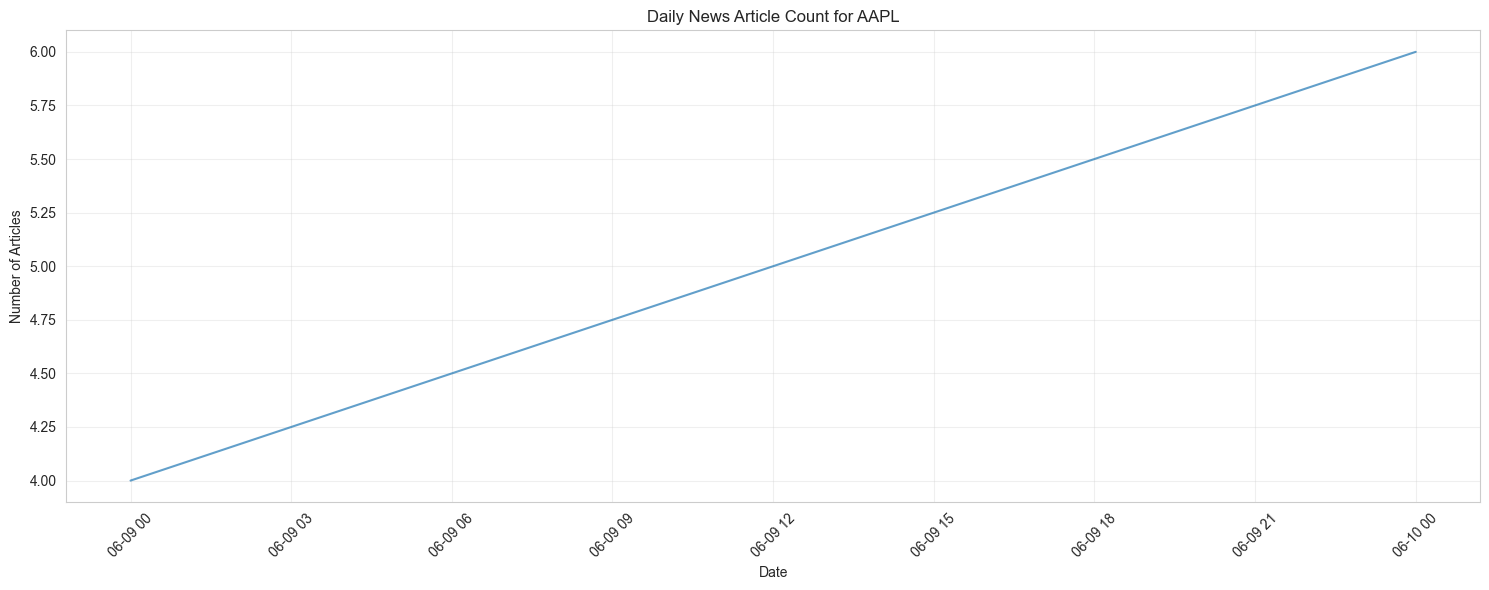

In [11]:
# Create daily news aggregation for correlation analysis
daily_news_agg = date_aligner.create_daily_news_aggregation(aligned_news)

print("📈 Daily News Aggregation:")
print(f"Shape: {daily_news_agg.shape}")
display(daily_news_agg.head())

# Visualize news frequency over time
plt.figure(figsize=(15, 6))
plt.plot(daily_news_agg['trading_date'], daily_news_agg['articles_count'], alpha=0.7)
plt.title(f'Daily News Article Count for {analysis_stock}')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Sentiment Analysis

In [12]:
# Initialize sentiment analyzer
sentiment_analyzer = SentimentAnalyzer(
    text_column='headline',
    include_textblob=True,
    include_vader=True,
    include_financial_lexicon=True
)

print("🔍 Performing sentiment analysis on news headlines...")

# Perform sentiment analysis on aligned news
news_with_sentiment = sentiment_analyzer.analyze_sentiment(aligned_news)

print(f"✅ Sentiment analysis completed!")
print(f"Shape: {news_with_sentiment.shape}")
print(f"New columns added: {set(news_with_sentiment.columns) - set(aligned_news.columns)}")

🔍 Performing sentiment analysis on news headlines...
✅ Sentiment analysis completed!
Shape: (20, 29)
New columns added: {'vader_compound', 'financial_sentiment_intensity', 'textblob_sentiment', 'financial_positive_count', 'financial_neutral_count', 'ensemble_sentiment_score', 'vader_sentiment', 'vader_neutral', 'textblob_subjectivity', 'textblob_polarity', 'financial_net_sentiment', 'vader_negative', 'vader_positive', 'financial_total_sentiment_words', 'financial_sentiment', 'financial_negative_count', 'ensemble_sentiment'}


In [13]:
# Display sentiment analysis results
sentiment_columns = [col for col in news_with_sentiment.columns if 'sentiment' in col.lower()]
display(news_with_sentiment[['headline'] + sentiment_columns].head())
# Get sentiment summary
sentiment_summary = sentiment_analyzer.get_sentiment_summary(news_with_sentiment)
print("📊 Sentiment Analysis Summary:")
for key, value in sentiment_summary.items():
    print(f"{key}: {value}")

,headline,textblob_sentiment,vader_sentiment,financial_total_sentiment_words,financial_net_sentiment,financial_sentiment_intensity,financial_sentiment,ensemble_sentiment_score,ensemble_sentiment
6686,Why Apple's Stock Is Trading Higher Today,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6687,Apple Could Announce In-House Chips For Macs A...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6688,Apple shares are trading higher despite market...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6689,"Sonos Shares Spike To Session High, Now Up 9.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6680,Tech Stocks And FAANGS Strong Again To Start D...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


📊 Sentiment Analysis Summary:
total_articles: 20
sentiment_methods: ['textblob', 'vader', 'financial_lexicon']
textblob_sentiment_distribution: {'neutral': 7, 'positive': 3, 'negative': 0}
textblob_avg_polarity: 0.13548484848484849
textblob_avg_subjectivity: 0.2757272727272727
vader_sentiment_distribution: {'positive': 6, 'neutral': 4, 'negative': 0}
vader_avg_compound: 0.21806999999999999
financial_sentiment_distribution: {'neutral': 5, 'positive': 5, 'negative': 0}
financial_avg_net_sentiment: 0.6
ensemble_sentiment_distribution: {'positive': 8, 'neutral': 2, 'negative': 0}
ensemble_avg_score: 0.21136514286479807


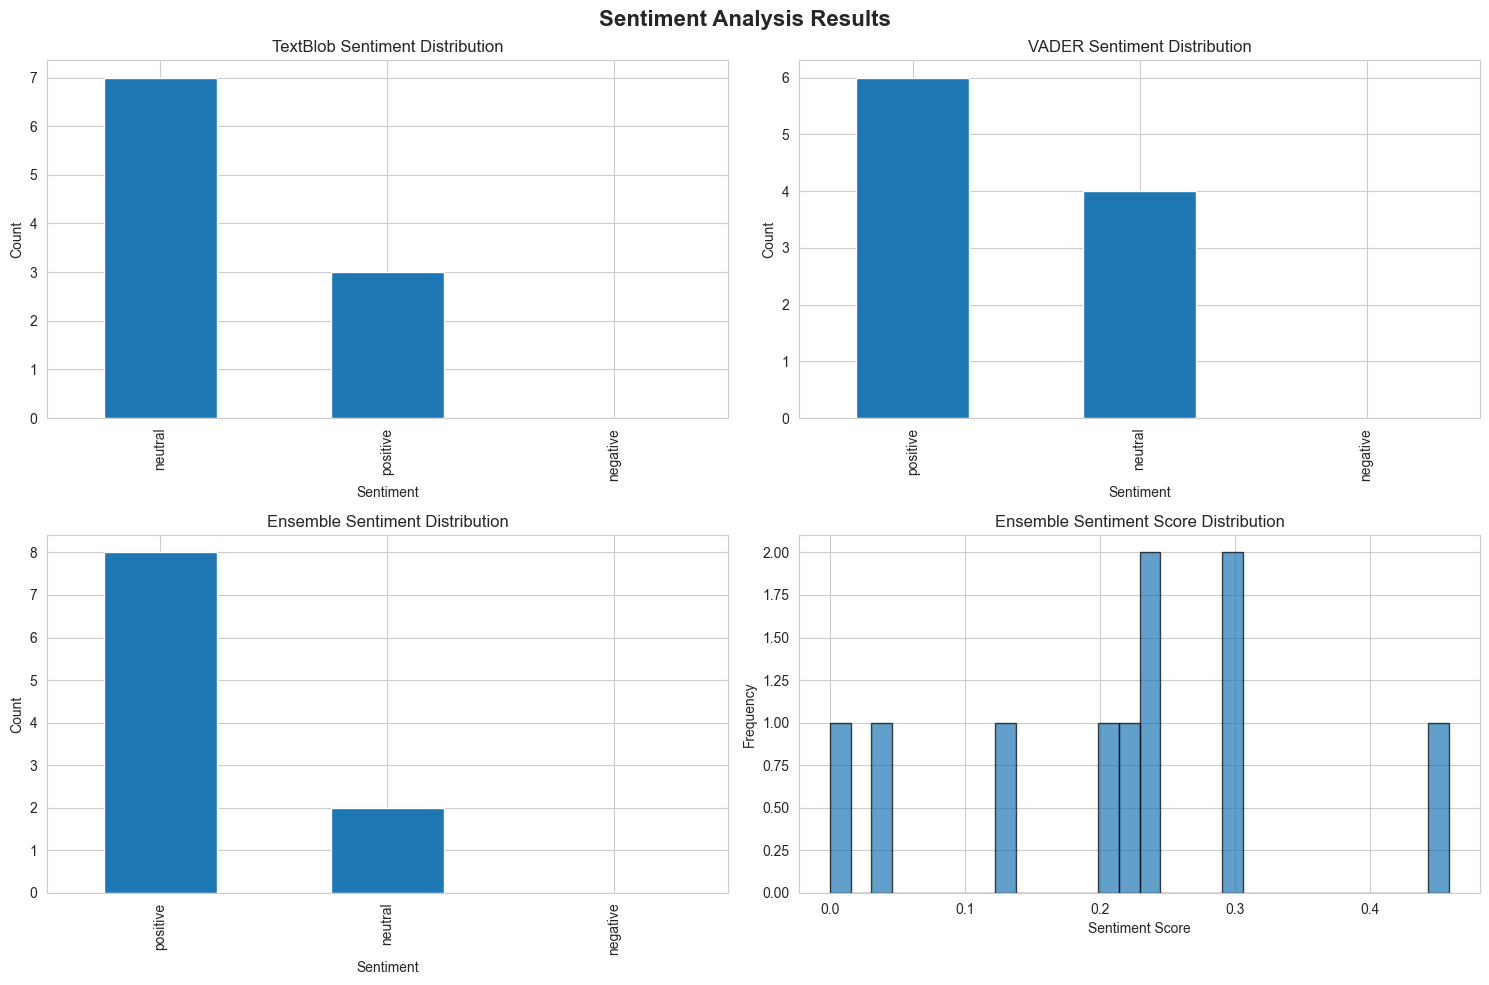

In [14]:
# Visualize sentiment distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Sentiment Analysis Results', fontsize=16, fontweight='bold')

# TextBlob sentiment distribution
if 'textblob_sentiment' in news_with_sentiment.columns:
    news_with_sentiment['textblob_sentiment'].value_counts().plot(kind='bar', ax=axes[0, 0])
    axes[0, 0].set_title('TextBlob Sentiment Distribution')
    axes[0, 0].set_xlabel('Sentiment')
    axes[0, 0].set_ylabel('Count')

# VADER sentiment distribution
if 'vader_sentiment' in news_with_sentiment.columns:
    news_with_sentiment['vader_sentiment'].value_counts().plot(kind='bar', ax=axes[0, 1])
    axes[0, 1].set_title('VADER Sentiment Distribution')
    axes[0, 1].set_xlabel('Sentiment')
    axes[0, 1].set_ylabel('Count')

# Ensemble sentiment distribution
if 'ensemble_sentiment' in news_with_sentiment.columns:
    news_with_sentiment['ensemble_sentiment'].value_counts().plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_title('Ensemble Sentiment Distribution')
    axes[1, 0].set_xlabel('Sentiment')
    axes[1, 0].set_ylabel('Count')

# Sentiment score distribution
if 'ensemble_sentiment_score' in news_with_sentiment.columns:
    axes[1, 1].hist(news_with_sentiment['ensemble_sentiment_score'], bins=30, edgecolor='black', alpha=0.7)
    axes[1, 1].set_title('Ensemble Sentiment Score Distribution')
    axes[1, 1].set_xlabel('Sentiment Score')
    axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [15]:
# Aggregate daily sentiment scores
daily_sentiment = sentiment_analyzer.aggregate_daily_sentiment(
    news_with_sentiment, date_column='trading_date'
)

print("📅 Daily Sentiment Aggregation:")
print(f"Shape: {daily_sentiment.shape}")
display(daily_sentiment.head())

# Detect sentiment extremes
extremes = sentiment_analyzer.detect_sentiment_extremes(news_with_sentiment)
print(f"\n🎯 Detected {len(extremes)} extreme sentiment articles")
if len(extremes) > 0:
    display(extremes[['headline', 'ensemble_sentiment_score', 'sentiment_z_score', 'extreme_type']].head())

📅 Daily Sentiment Aggregation:
Shape: (2, 13)


,trading_date,daily_articles_count,ensemble_sentiment_score_mean,ensemble_sentiment_score_std,ensemble_sentiment_score_min,ensemble_sentiment_score_max,textblob_sentiment_<lambda>,vader_sentiment_<lambda>,financial_total_sentiment_words_<lambda>,financial_net_sentiment_<lambda>,financial_sentiment_intensity_<lambda>,financial_sentiment_<lambda>,ensemble_sentiment_<lambda>
0,2020-06-09,4,NaN,NaN,NaN,NaN,neutral,neutral,neutral,neutral,neutral,neutral,neutral
1,2020-06-10,6,NaN,NaN,NaN,NaN,neutral,neutral,neutral,neutral,neutral,neutral,neutral



🎯 Detected 2 extreme sentiment articles


,headline,ensemble_sentiment_score,sentiment_z_score,extreme_type
4,NaN,0.45845,1.861664,very_positive
1,NaN,0.00000,-1.592536,very_negative


## 5. Stock Return Calculation

In [16]:
# Initialize correlation analyzer
correlation_analyzer = CorrelationAnalyzer(
    date_column='trading_date',
    return_column='daily_return',
    sentiment_column='ensemble_sentiment_score'
)

# Calculate daily returns for the aligned stock data
print(f"📈 Calculating daily returns for {analysis_stock}...")
aligned_stock['trading_date'] = aligned_stock['Date'].dt.date
stock_with_returns = correlation_analyzer.calculate_daily_returns(aligned_stock, 'Close')

print(f"✅ Returns calculated!")
print(f"Shape: {stock_with_returns.shape}")
print(f"New columns: {set(stock_with_returns.columns) - set(aligned_stock.columns)}")

# Display return statistics
return_stats = stock_with_returns['daily_return'].describe()
print(f"\n📊 Daily Return Statistics for {analysis_stock}:")
print(return_stats)

📈 Calculating daily returns for AAPL...
✅ Returns calculated!
Shape: (2, 16)
New columns: {'rolling_return_5d', 'rolling_volatility', 'return_direction', 'rolling_return_10d', 'daily_return', 'daily_return_abs'}

📊 Daily Return Statistics for AAPL:
count    1.000000
mean     2.572751
std           NaN
min      2.572751
25%      2.572751
50%      2.572751
75%      2.572751
max      2.572751
Name: daily_return, dtype: float64


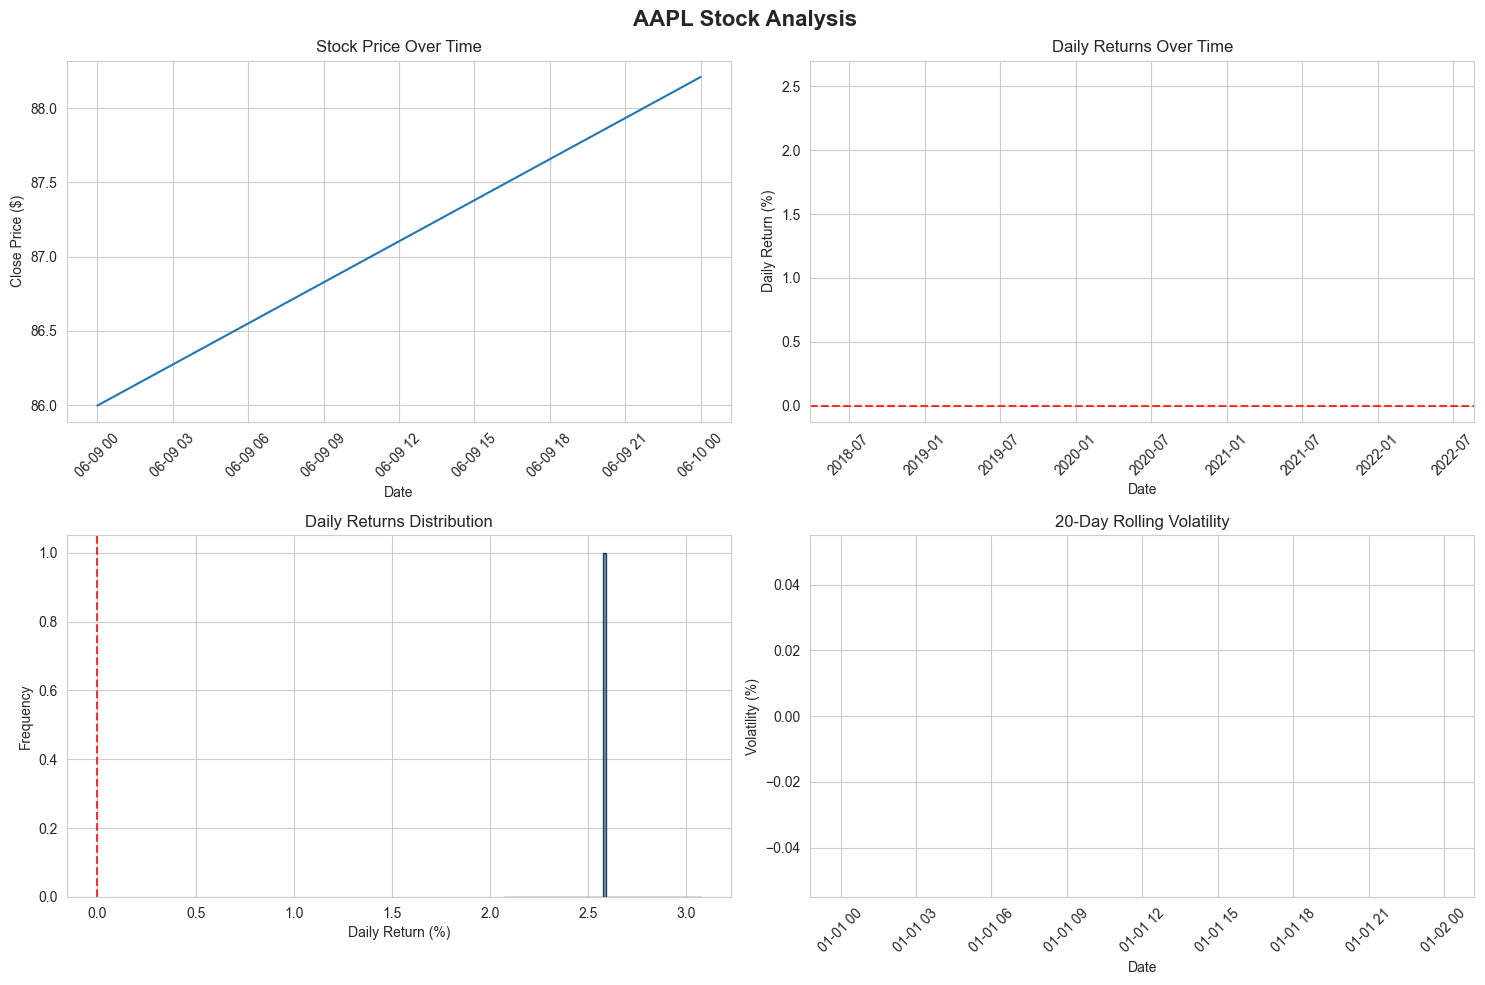

In [17]:
# Visualize stock returns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'{analysis_stock} Stock Analysis', fontsize=16, fontweight='bold')

# Price over time
axes[0, 0].plot(stock_with_returns['Date'], stock_with_returns['Close'])
axes[0, 0].set_title('Stock Price Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Close Price ($)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Daily returns over time
axes[0, 1].plot(stock_with_returns['Date'], stock_with_returns['daily_return'], alpha=0.7)
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[0, 1].set_title('Daily Returns Over Time')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Daily Return (%)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Return distribution
axes[1, 0].hist(stock_with_returns['daily_return'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='red', linestyle='--', alpha=0.8)
axes[1, 0].set_title('Daily Returns Distribution')
axes[1, 0].set_xlabel('Daily Return (%)')
axes[1, 0].set_ylabel('Frequency')

# Rolling volatility
axes[1, 1].plot(stock_with_returns['Date'], stock_with_returns['rolling_volatility'])
axes[1, 1].set_title('20-Day Rolling Volatility')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Volatility (%)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Correlation Analysis

In [18]:
# Prepare correlation data by merging sentiment and return data
print("🔗 Preparing correlation analysis data...")

# Merge daily sentiment aggregation with stock returns
correlation_data = pd.merge(
    daily_sentiment,
    stock_with_returns[['trading_date', 'daily_return', 'daily_return_abs', 'return_direction', 'rolling_volatility']],
    on='trading_date',
    how='inner'
)

print("✅ Correlation data prepared!")
print(f"Shape: {correlation_data.shape}")
print(f"Date range: {correlation_data['trading_date'].min()} to {correlation_data['trading_date'].max()}")

# Display sample
display(correlation_data.head())

🔗 Preparing correlation analysis data...
✅ Correlation data prepared!
Shape: (2, 17)
Date range: 2020-06-09 to 2020-06-10


,trading_date,daily_articles_count,ensemble_sentiment_score_mean,ensemble_sentiment_score_std,ensemble_sentiment_score_min,ensemble_sentiment_score_max,textblob_sentiment_<lambda>,vader_sentiment_<lambda>,financial_total_sentiment_words_<lambda>,financial_net_sentiment_<lambda>,financial_sentiment_intensity_<lambda>,financial_sentiment_<lambda>,ensemble_sentiment_<lambda>,daily_return,daily_return_abs,return_direction,rolling_volatility
0,2020-06-09,4,NaN,NaN,NaN,NaN,neutral,neutral,neutral,neutral,neutral,neutral,neutral,NaN,NaN,neutral,NaN
1,2020-06-10,6,NaN,NaN,NaN,NaN,neutral,neutral,neutral,neutral,neutral,neutral,neutral,2.572751,2.572751,positive,NaN


In [19]:
# Test basic correlation between ensemble sentiment and daily returns
if 'ensemble_sentiment_score_mean' in correlation_data.columns:
    sentiment_col = 'ensemble_sentiment_score_mean'
else:
    sentiment_col = [col for col in correlation_data.columns if 'ensemble_sentiment_score' in col][0]

basic_correlation = correlation_analyzer.test_correlation_significance(
    correlation_data, sentiment_col, 'daily_return'
)

print("📊 Basic Correlation Analysis Results:")
for key, value in basic_correlation.items():
    print(f"{key}: {value}")

# Additional correlation tests
correlations = {
    'Pearson': correlation_analyzer.test_correlation_significance(
        correlation_data, sentiment_col, 'daily_return', method='pearson'
    ),
    'Spearman': correlation_analyzer.test_correlation_significance(
        correlation_data, sentiment_col, 'daily_return', method='spearman'
    )
}

print("\n🔍 Correlation Analysis Summary:")
for method, result in correlations.items():
    print(f"{method}: r={result['correlation']:.4f}, p={result['p_value']:.4f}, {result['interpretation']}")

📊 Basic Correlation Analysis Results:
correlation: nan
p_value: nan
significant: False
n_observations: 0
method: pearson
interpretation: Insufficient data

🔍 Correlation Analysis Summary:
Pearson: r=nan, p=nan, Insufficient data
Spearman: r=nan, p=nan, Insufficient data


In [22]:
# Generate comprehensive correlation report
correlation_report = correlation_analyzer.generate_correlation_report(
    correlation_data, sentiment_col, 'daily_return'
)

print("📋 Comprehensive Correlation Report:")
print("\n📊 Data Summary:")
for key, value in correlation_report['data_summary'].items():
    print(f"{key}: {value}")

print("\n🔍 Basic Correlation:")
basic = correlation_report['basic_correlation']
print(f"Correlation: {basic['correlation']:.4f}")
print(f"P-value: {basic['p_value']:.4f}")
print(f"Significant: {basic['significant']}")
print(f"Interpretation: {basic['interpretation']}")

print("\n📈 Additional Statistics:")
for key, value in correlation_report['additional_stats'].items():
    print(f"{key}: {value:.4f}")

📋 Comprehensive Correlation Report:

📊 Data Summary:
total_observations: 2
date_range: (datetime.date(2020, 6, 9), datetime.date(2020, 6, 10))
sentiment_stats: {'count': 0.0, 'mean': nan, 'std': nan, 'min': nan, '25%': nan, '50%': nan, '75%': nan, 'max': nan}
return_stats: {'count': 1.0, 'mean': 2.5727510551937005, 'std': nan, 'min': 2.5727510551937005, '25%': 2.5727510551937005, '50%': 2.5727510551937005, '75%': 2.5727510551937005, 'max': 2.5727510551937005}

🔍 Basic Correlation:
Correlation: nan
P-value: nan
Significant: False
Interpretation: Insufficient data

📈 Additional Statistics:
data_completeness: 0.0000
sentiment_skewness: nan
return_skewness: nan
sentiment_kurtosis: nan
return_kurtosis: nan
